In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_importance
import shap

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# XGBoost 

XGBoost is a gradient-boosted decision tree ML framework that uses supervised machine learning, decision trees, ensemble learning, and gradient boosting to perform tasks such as regression, classification and ranking. 

XGBoost gradient-boosted decision trees (GBDTs) work by iteratively training an ensemble of decision trees in parallel, where each model iteration uses the error residuals of the previous model to fit the next model (until no more improvements can be made) and the final model prediction represents the weighted sum of all of the tree predictions. The gradient boosting approach effectively minimizes model bias and underfitting.

The XGBoost GBDT approach differs from Random Forests, where full decision trees are built in parallel from random bootstrap samples of the data set and the final modele prediction is an average of all of the decision tree predictions. The random forest approach uses this bagging approach to minimize model variance and overfitting.


### Prepare Dataset

In [2]:
# Load the Digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix format (XGBoost's internal data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Define XGBoost parameters

In [3]:

params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 10,  # Number of classes in the target variable
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'mlogloss'  # Use log loss for evaluation
}


### Train XGBoost Model

In [4]:
# Train the XGBoost model with early stopping
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_boost_round=20, evals=evals, early_stopping_rounds=10)


[0]	train-mlogloss:1.97823	test-mlogloss:1.98472
[1]	train-mlogloss:1.75295	test-mlogloss:1.76458


[2]	train-mlogloss:1.57721	test-mlogloss:1.59113
[3]	train-mlogloss:1.43146	test-mlogloss:1.45150
[4]	train-mlogloss:1.30892	test-mlogloss:1.33262
[5]	train-mlogloss:1.20072	test-mlogloss:1.22812
[6]	train-mlogloss:1.10850	test-mlogloss:1.14004
[7]	train-mlogloss:1.02640	test-mlogloss:1.06159
[8]	train-mlogloss:0.95260	test-mlogloss:0.98996
[9]	train-mlogloss:0.88685	test-mlogloss:0.92595
[10]	train-mlogloss:0.82665	test-mlogloss:0.87034
[11]	train-mlogloss:0.77196	test-mlogloss:0.81887
[12]	train-mlogloss:0.72216	test-mlogloss:0.77137
[13]	train-mlogloss:0.67711	test-mlogloss:0.72879
[14]	train-mlogloss:0.63496	test-mlogloss:0.68790
[15]	train-mlogloss:0.59686	test-mlogloss:0.65182
[16]	train-mlogloss:0.56231	test-mlogloss:0.61841
[17]	train-mlogloss:0.52967	test-mlogloss:0.58829
[18]	train-mlogloss:0.49865	test-mlogloss:0.55921
[19]	train-mlogloss:0.47027	test-mlogloss:0.53194


### Evaluate Model Performance 

In [5]:
# Make predictions on the test set
y_pred = model.predict(dtest)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Conusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.93
Train Accuracy: 0.9708
Test Accuracy: 0.9306

Confusion Matrix:
[[32  0  0  0  1  0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0  1]
 [ 0  0 31  0  0  0  1  0  1  0]
 [ 0  0  0 31  0  1  0  0  2  0]
 [ 0  2  0  0 42  0  1  1  0  0]
 [ 1  0  0  0  0 44  0  0  0  2]
 [ 0  0  0  0  0  1 33  0  1  0]
 [ 0  0  0  0  0  0  0 32  0  2]
 [ 0  2  0  0  0  0  0  0 28  0]
 [ 0  0  1  0  0  0  0  1  3 35]]

Precision: 0.9340072251985098
Recall: 0.9305555555555556
F1-Score: 0.9313050372626737


In [6]:
y_pred_proba = model.predict(dtest, output_margin=True)
logloss = log_loss(y_test, y_pred_proba)
print("Log Loss:", logloss)

Log Loss: 0.6404624139225474


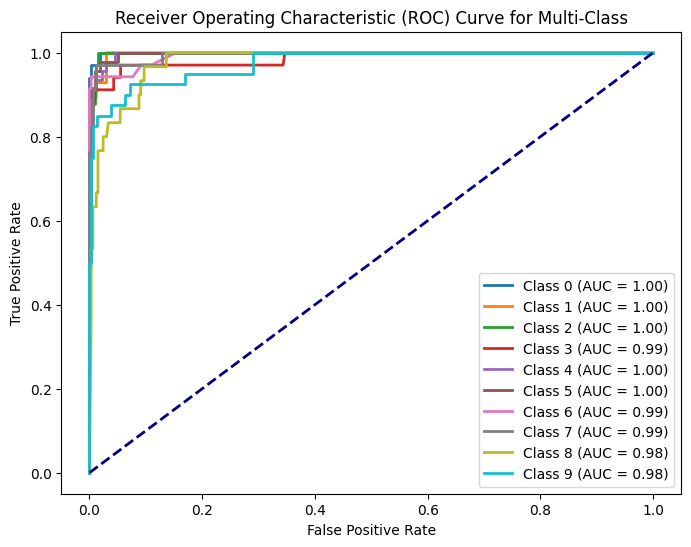

In [7]:
# Multiclass classification
n_classes = 10  

# Convert labels to binary format
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Use the predict_proba method to get class probabilities
y_pred_proba = model.predict(dtest, output_margin=True)

# Initialize variables for ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

### Model Interpretability: Feature Importance

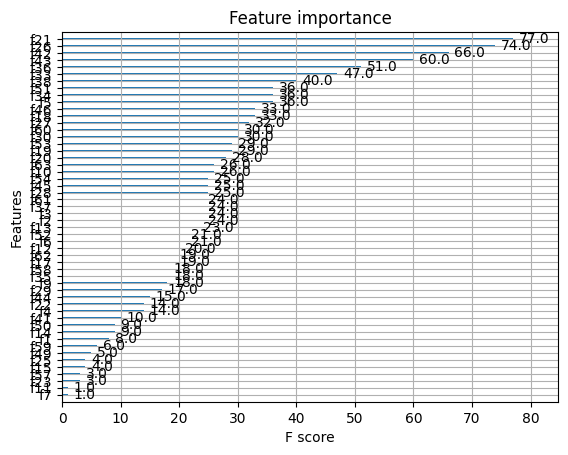

In [8]:
# Plotting feature importance
plot_importance(model)
plt.show()

#### Gini Importance

Gini importance measure of feature importance in a decision tree-based models. It is calculated based on the Gini impurity criterion, which measures the degree of impurity or disorder in a set of data points Gini importance quantifies how often a feature is used to split the data across all trees and how much it contributes to the reduction in impurity. This aids in model interpretability by providing insights into which features are more influential in making predictions.

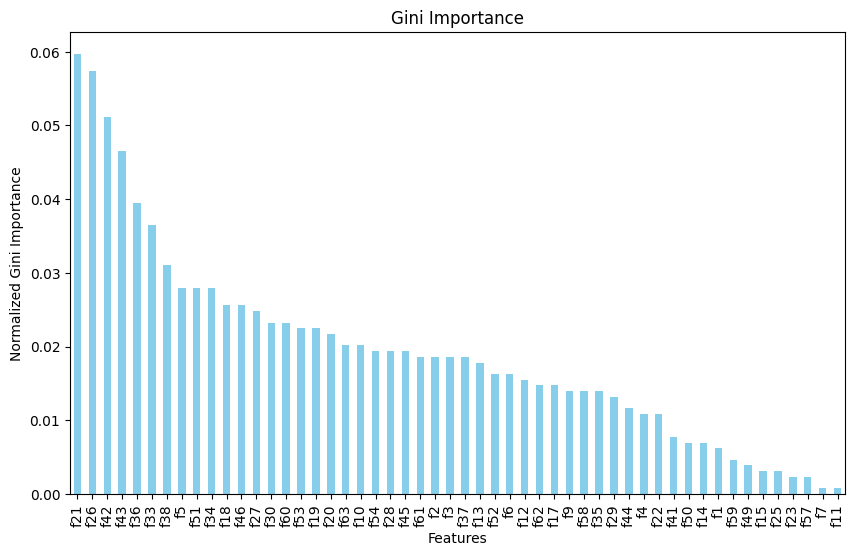

In [9]:
# Get the default feature importance scores
default_importance = model.get_score(importance_type='weight')

# Calculate Gini importance
total_gini = sum(default_importance.values())
gini_importance = {feature: importance / total_gini for feature, importance in default_importance.items()}

# Create a bar plot for Gini importance
sorted_gini_importance = pd.Series(gini_importance).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sorted_gini_importance.plot(kind='bar', color='skyblue')
plt.title('Gini Importance')
plt.ylabel('Normalized Gini Importance')
plt.xlabel('Features')
plt.show()

#### SHAP (SHapley Additive exPlanations)

SHAP is a model-agnostic framework used to interpret ML model output, e.g., feature importance. SHAP values allocate the contribution of each feature to the model's prediction, taking into account the interactions and dependencies between features.

[13:28:19] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


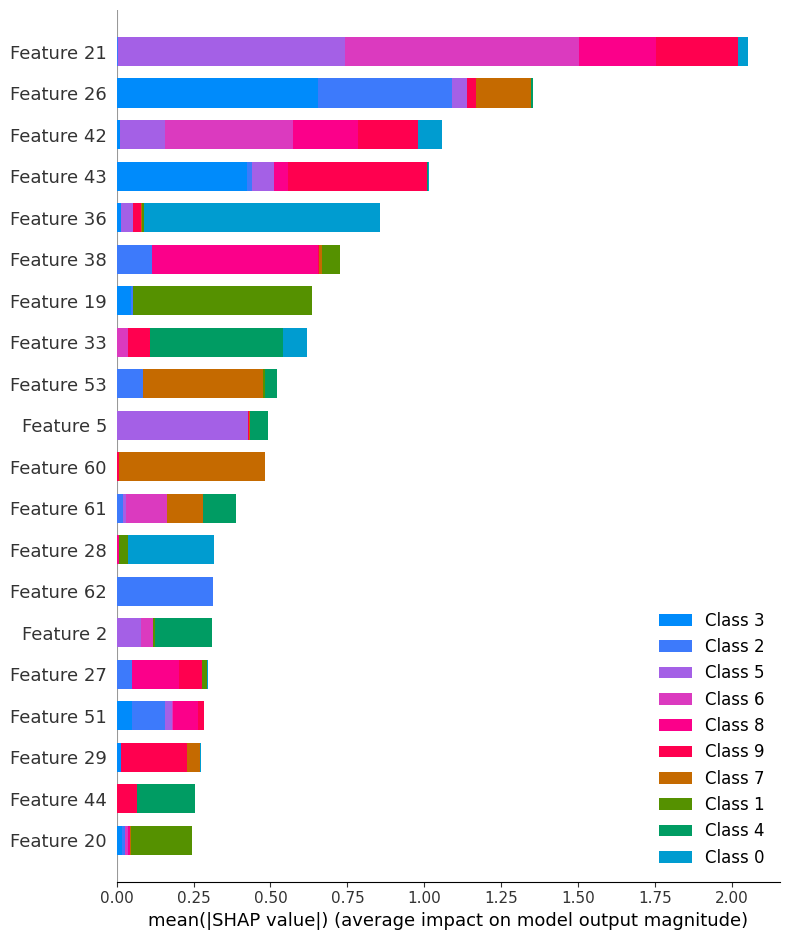

In [10]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot without explicit feature names
shap.summary_plot(shap_values, X_test)

plt.show()